In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from cleaning_script import NOMINAL, ORDINAL, CONTINUOUS, DISCRETE, feature_plot

# 2 - Data Correlation Notebook
---

### Contents

1. [Data Cleaning](../code/data_cleaning.ipynb) 
2. [Data Correlation](../code/data_correlation.ipynb) [This Notebook]
3. [Data Visualization](../code/visualizations.ipynb)
4. [Regression Model Comparison](../code/regression_model.ipynb)
---

### Notebook Purpose

This notebook uses the cleaned data from notebook_1 and begins to examine the features for correlative relationships to our target variable, `salesprice`. 

A number of missing values will be imputed once the distributions have been studied. In order to find and engineer features that have potential predictive power, we will be heavily leveraging the Pearson Correlation coefficient: $R$. The correlation coefficient describes how one variable moves in relation to another. A positive correlation indicates that the two move in the same direction, with a value of $1$ denoting a perfect positive correlation. A value of $-1$ shows a perfect negative, or inverse, correlation, while $0$ means no linear correlation exists. By sifting features through correlation matrices, we can examine the interactions between the feature and saleprice.

Read in clean .CSV data

In [102]:
# train
house_train = pd.read_csv('../datasets/house_train_clean.csv')

# test
house_test = pd.read_csv('../datasets/house_test_clean.csv')

# make dataframes wider
pd.set_option('display.max_columns', 100)

Modify `ORDINAL`, `NOMINAL`, `CONTINUOUS` and `DISCRETE` variables based on whatever info we've dropped or kept from the first notebook

In [104]:
ORDINAL = [x for x in ORDINAL if x in house_train.columns]
NOMINAL = [x for x in NOMINAL if x in house_train.columns]
CONTINUOUS = [x for x in CONTINUOUS if x in house_train.columns]
DISCRETE = [x for x in DISCRETE if x in house_train.columns]

# Look for Correlations within Numerical Categories

In [105]:
# create helper function for plotting correlations
def plot_corr_heatmap(CATEGORY, title):
    COLUMNS = [x for x in CATEGORY]
    COLUMNS.append('saleprice')

    fig, ax = plt.subplots(figsize=(20,12))
    corr = house_train[COLUMNS].corr()
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.title(f'{title} Correlations')
    
    return sns.heatmap(corr, mask=mask, annot=True), corr['saleprice'], corr

# dictionary of correlative factors
correlative_factors = {}

# Discrete

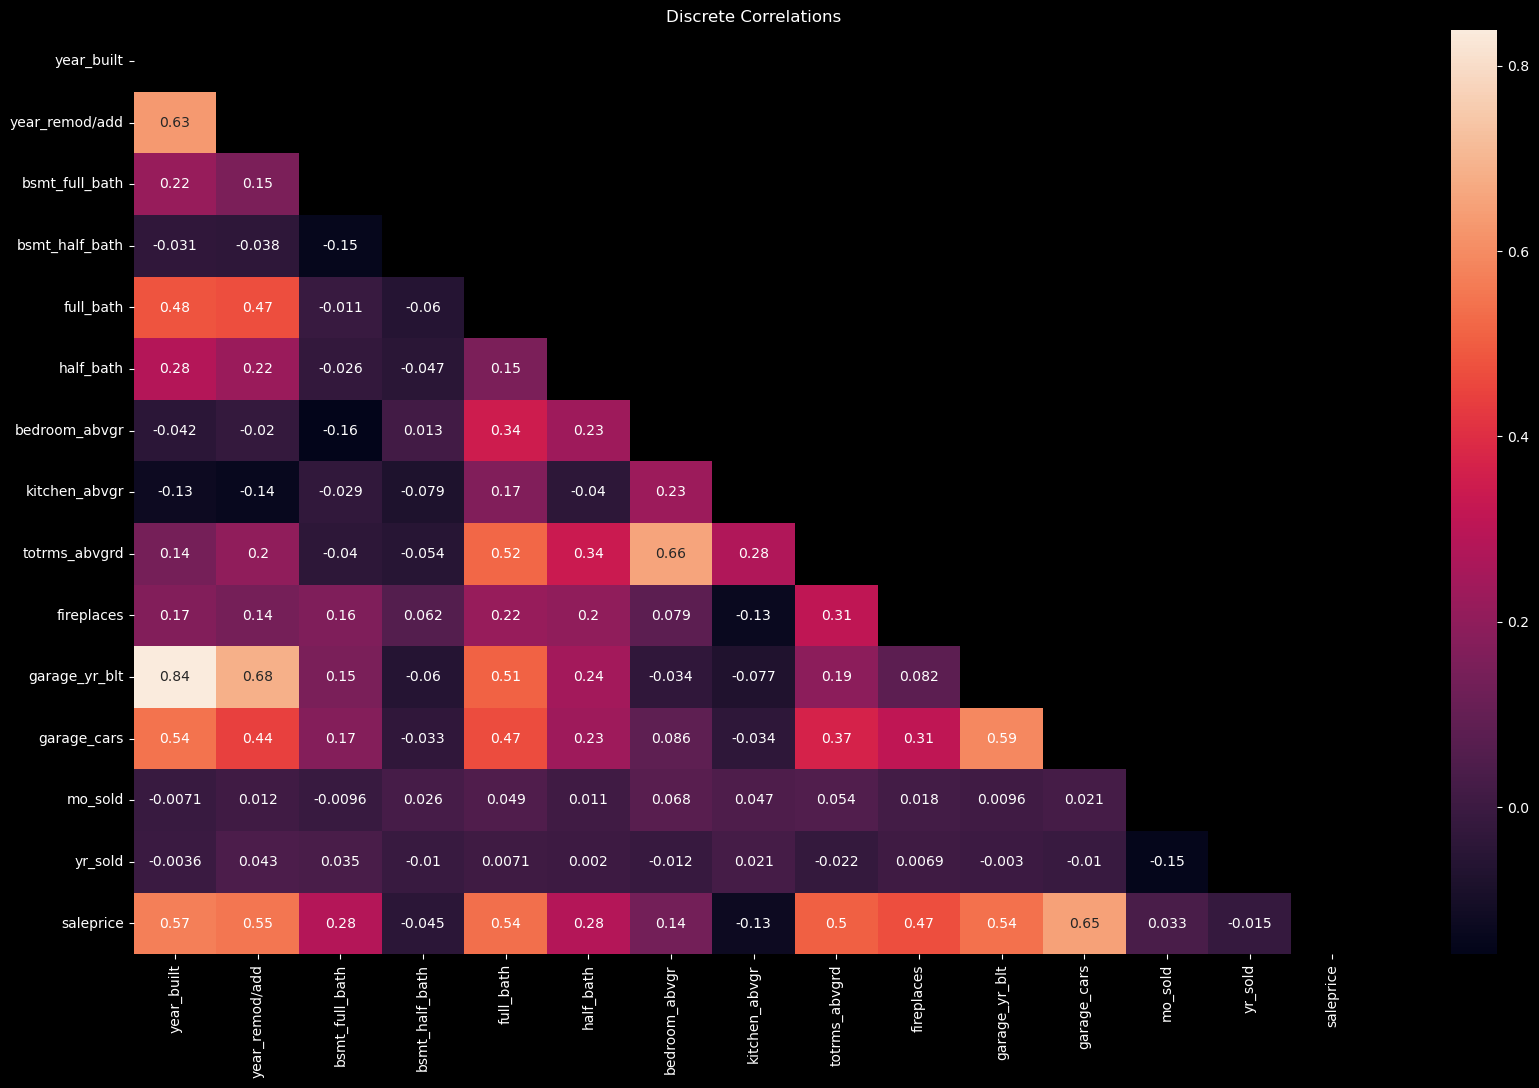

In [106]:
discrete_corrs = plot_corr_heatmap(DISCRETE, 'Discrete')

correlative_factors.update(discrete_corrs[1].to_dict())

### Continous

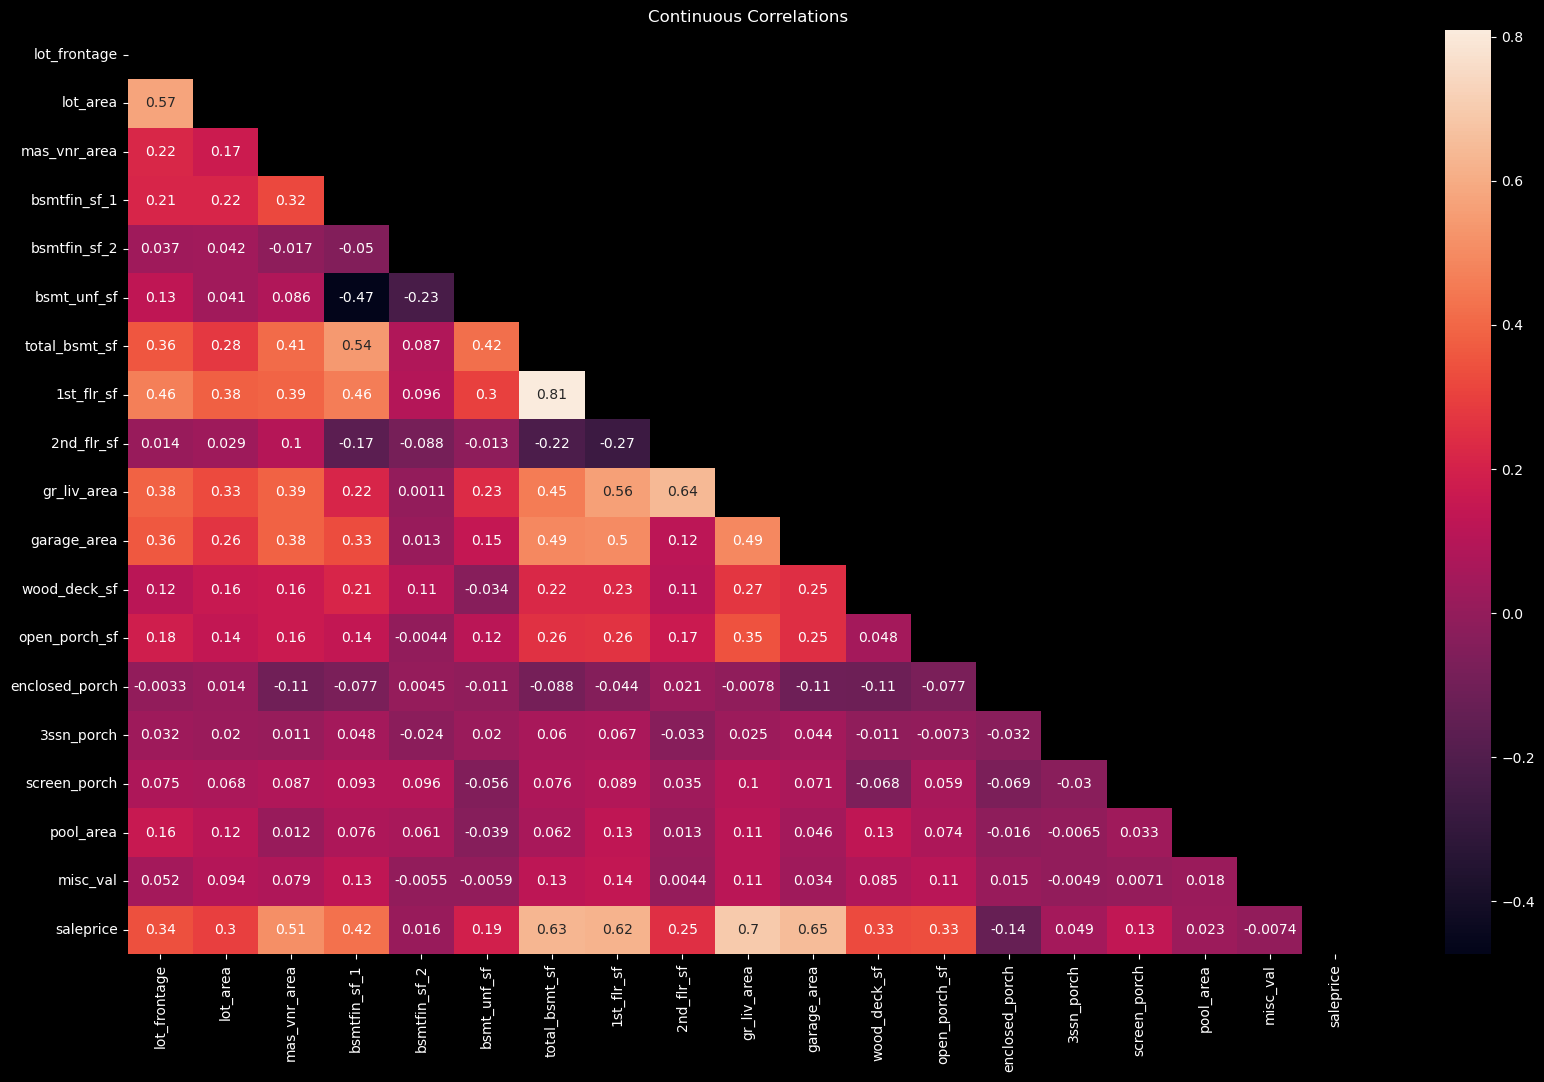

In [107]:
continuous_corrs = plot_corr_heatmap(CONTINUOUS, 'Continuous')

correlative_factors.update(continuous_corrs[1].to_dict())

### Ordinal

Theres clearly a lot of value in these ranked qualitative values, we'll make them numeric and see if we can get some more value. 

       
       ex	excellent
       gd	good
       ta	average/typical
       fa	fair
       po	poor

the following columns use this system:  
- exter_qual
- exter_cond
- bsmt_qual
- bsmt_cond
- bsmt_exposure
- heating_qc
- kitchen_qual
- garage_qual
- garage_cond

In [108]:
# functions to rank Ordinal quality ratings
def ordinal_to_numeric_expo(val):
    if val == 'Ex':
        return 4
    elif val == 'Gd':
        return 3
    elif val == 'TA':
        return 2
    elif val == 'Fa':
        return 1
    elif val == 'Po':
        return 0
    else:
        pass

def ordinal_to_numeric_glqna(val):
    if val == 'GLQ':
        return 6
    elif val == 'ALQ':
        return 5
    elif val == 'BLQ':
        return 4
    elif val == 'Rec':
        return 3
    elif val == 'LwQ':
        return 2
    elif val == 'Unf':
        return 1
    elif val == 'NA':
        return 0
    else:
        pass

def ordinal_to_numeric_functional(val):
    if val == 'Typ':
        return 3
    elif val == 'Min1':
        return 2
    elif val == 'Min2':
        return 1
    elif val == 'Mod':
        return 0
    elif val == 'Maj1':
        return -1
    elif val == 'Maj2':
        return -2
    elif val == 'Sev':
        return -3
    elif val == 'Sal':
        return -4
    else:
        pass

Find the columns that use the 'Ex - Po' rating schema

In [109]:
def ex_po(df):
    rank_words = ['Ex', 'Gd', 'TA','Fa', 'Po']
    rank_words = pd.Series(rank_words)
    columns_to_fix = []

# find columns, append to columns to fix
    for col in df[ORDINAL].columns:
        word_check = rank_words.isin(df[ORDINAL][col])
        if word_check.sum() > 0:
            columns_to_fix.append(col)
            
# convert columns to numeric values
    for col in columns_to_fix:
        df[col] = [ordinal_to_numeric_expo(val) for val in df[col]]

In [110]:
# expo train
ex_po(house_train)
# expo test
ex_po(house_test)

Basements

In [111]:
def glqna(df):
    basement_cols = ['bsmtfin_type_1', 'bsmtfin_type_2']

    for col in basement_cols:
        df[col] = [ordinal_to_numeric_glqna(val) for val in df[col]]

In [112]:
# glqna train
glqna(house_train)
# glqna test
glqna(house_test)

Functional

In [113]:
def functional(df):
    df['functional'] = [ordinal_to_numeric_functional(val) for val in df['functional']]

In [114]:
# functional train
functional(house_train)
# functional test
functional(house_test)

Ordinal Correlations

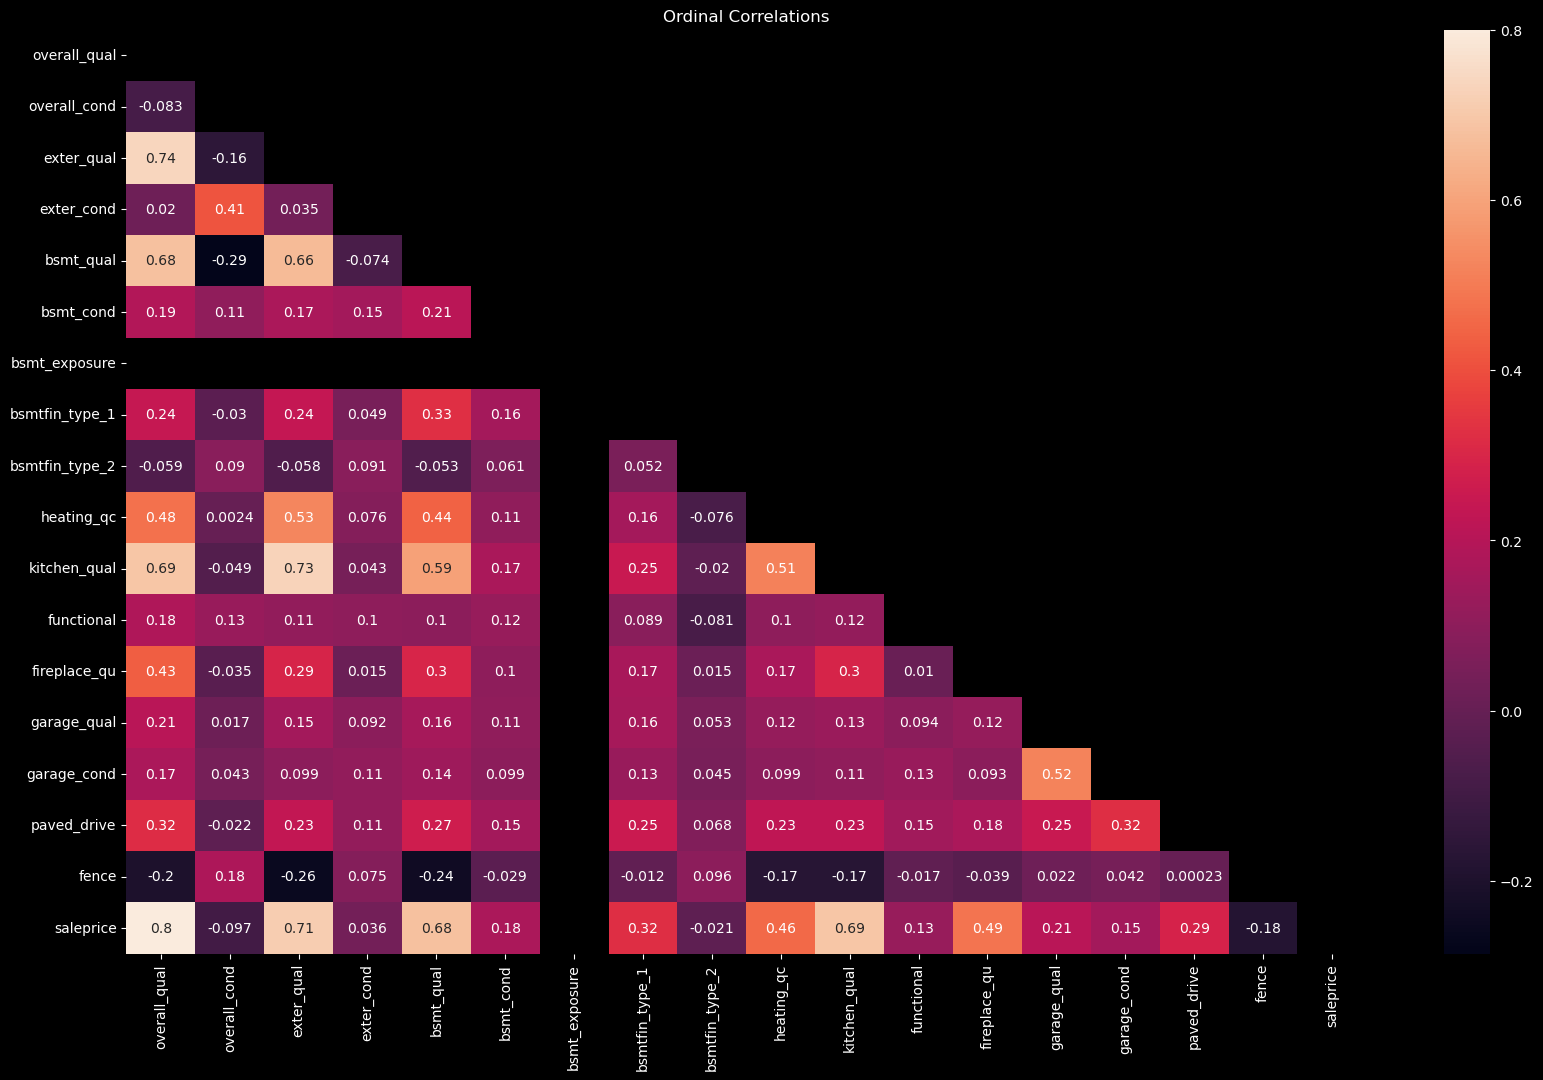

In [115]:
ordinal_corrs = plot_corr_heatmap(ORDINAL, 'Ordinal')

correlative_factors.update(ordinal_corrs[1].to_dict())

### Nominal

Condition 1 (Nominal): Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad
	
Condition 2 (Nominal): Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

These seem important! location, location, location. Let's make them numerical too. 

Location Dummies

In [116]:

# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['condition_1']).columns.to_list():
    NOMINAL.append(x)

Utility Dummies

In [117]:


# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['utilities']).columns.to_list():
    NOMINAL.append(x)

Roof Dummies

In [118]:


# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['roof_matl']).columns.to_list():
    NOMINAL.append(x)

Foundation Dummies

In [119]:


# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['foundation']).columns.to_list():
    NOMINAL.append(x)

Building Dummies

In [120]:


# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['bldg_type']).columns.to_list():
    NOMINAL.append(x)

Exterior Dummies

In [121]:


# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['exterior_1st']).columns.to_list():
    NOMINAL.append(x)

Neighborhood Dummies

In [122]:


# add dummy columns back to NOMINAL so we can call it below
for x in pd.get_dummies(house_train['neighborhood']).columns.to_list():
    NOMINAL.append(x)

In [123]:
house_train = pd.concat([house_train, pd.get_dummies(house_train['condition_1'], drop_first=True),
                                    pd.get_dummies(house_train['neighborhood'],drop_first=True),
                                    pd.get_dummies(house_train['bldg_type'], drop_first=True),
                                    pd.get_dummies(house_train['exterior_1st'], drop_first=True),
                                    pd.get_dummies(house_train['foundation'], drop_first=True),
                                    pd.get_dummies(house_train['roof_matl'], drop_first=True),
                                    pd.get_dummies(house_train['utilities'], drop_first=True),
                                    pd.get_dummies(house_train['condition_1'],drop_first=True)
], axis=1)
# test
house_test = pd.concat([house_test, pd.get_dummies(house_test['condition_1'], drop_first=True),
                                    pd.get_dummies(house_test['neighborhood'],drop_first=True),
                                    pd.get_dummies(house_test['bldg_type'], drop_first=True),
                                    pd.get_dummies(house_test['exterior_1st'], drop_first=True),
                                    pd.get_dummies(house_test['foundation'], drop_first=True),
                                    pd.get_dummies(house_test['roof_matl'], drop_first=True),
                                    pd.get_dummies(house_test['utilities'], drop_first=True),
                                    pd.get_dummies(house_test['condition_1'],drop_first=True)
], axis=1)


# remove the dropped dummy columns from NOMINAL
for x in ['Artery', 'AllPub', 'ClyTile', 'BrkTil', '1Fam', 'AsbShng', 'Blmngtn']:
    NOMINAL.remove(x)

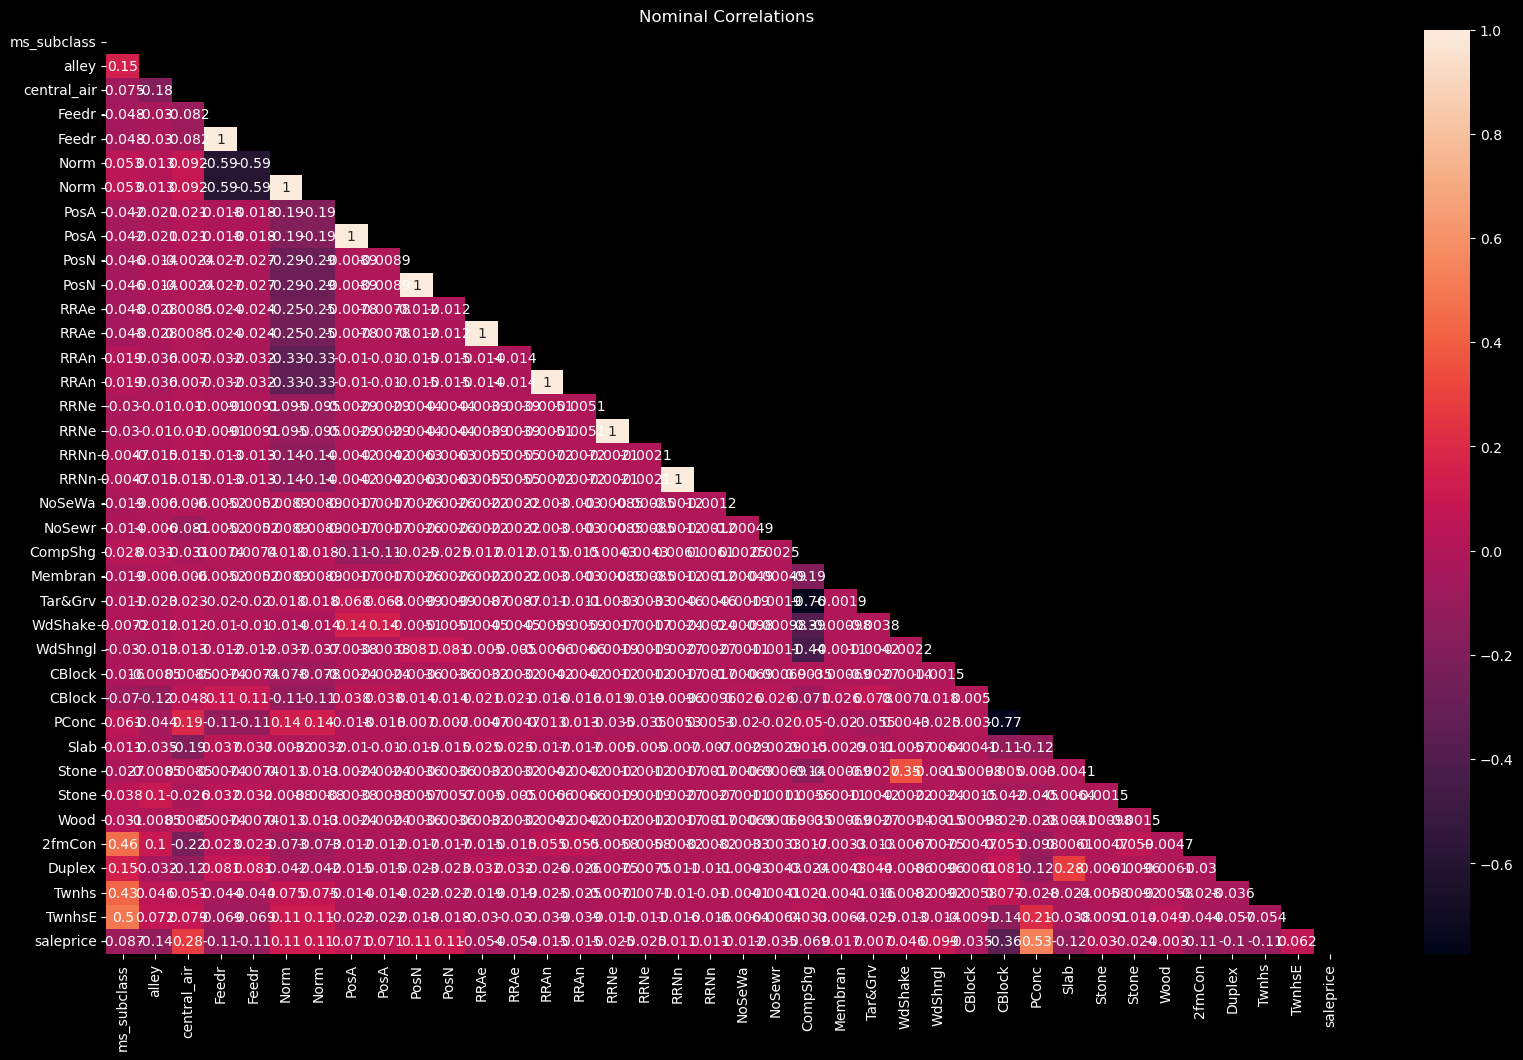

In [124]:
nominal_corrs_1 = plot_corr_heatmap(NOMINAL[:45], 'Nominal')


correlative_factors.update(nominal_corrs_1[1].to_dict())

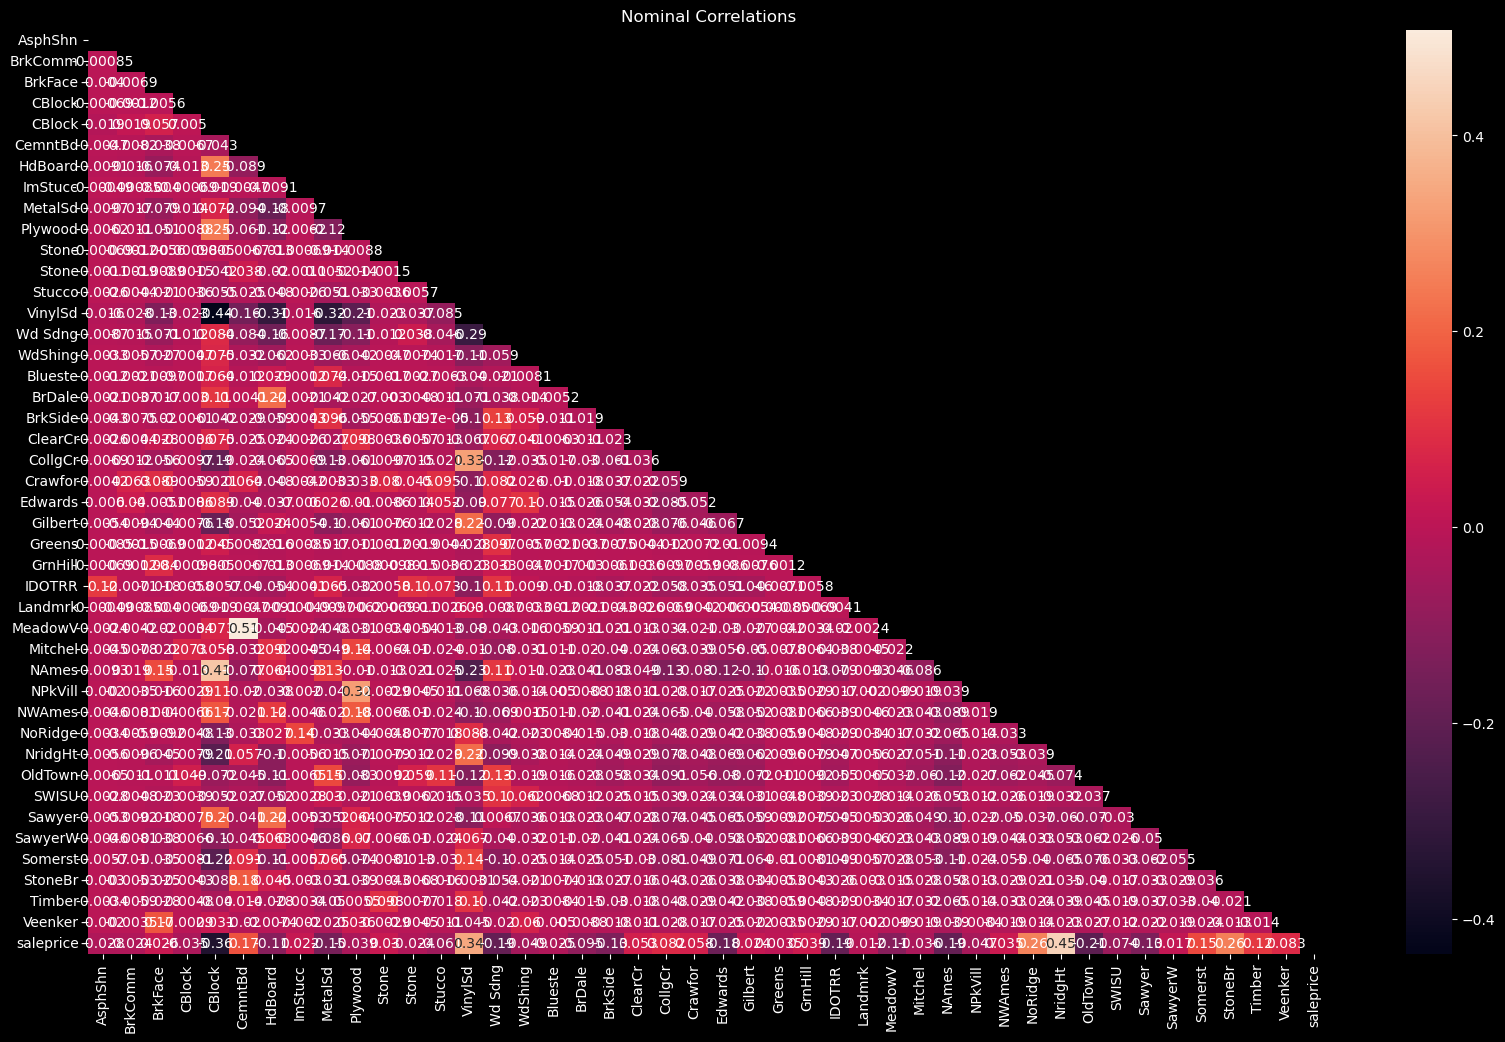

In [125]:
nominal_corrs = plot_corr_heatmap(NOMINAL[45:], 'Nominal')

correlative_factors.update(nominal_corrs_1[1].to_dict())

'Norm' 'PosA' and 'PosN' have a weak positive correlative effect and being near a railroad or busy thruway has a weak negative correlative effect

# Find Most Correlative Factors
- Gives us a place to start building new features from

In [126]:
correlative_factors = {k:v for k,v in correlative_factors.items() if np.abs(v) > .1 and k != 'saleprice'}

# correlative_factors.pop('saleprice')

# Missing Value Imputation for Correlative Factors

In [127]:
missing_train = house_train[correlative_factors.keys()].isnull().sum().sort_values(ascending = False).loc[lambda x: x > 0]

missing_test = house_test[correlative_factors.keys()].isnull().sum().sort_values(ascending = False).loc[lambda x: x > 0]

print(missing_train)
print('*' * 50)
print(missing_test)

lot_frontage      330
garage_qual       114
garage_cond       114
garage_yr_blt     114
bsmtfin_type_1     55
bsmt_cond          55
bsmt_qual          55
mas_vnr_area       22
bsmt_full_bath      2
garage_area         1
bsmt_unf_sf         1
bsmtfin_sf_1        1
total_bsmt_sf       1
garage_cars         1
dtype: int64
**************************************************
lot_frontage      160
garage_qual        45
garage_cond        45
garage_yr_blt      45
bsmt_qual          25
bsmtfin_type_1     25
bsmt_cond          25
mas_vnr_area        1
dtype: int64


`lot_frontage`

In [128]:
house_train.lot_frontage.mean()

69.05520046484602

<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

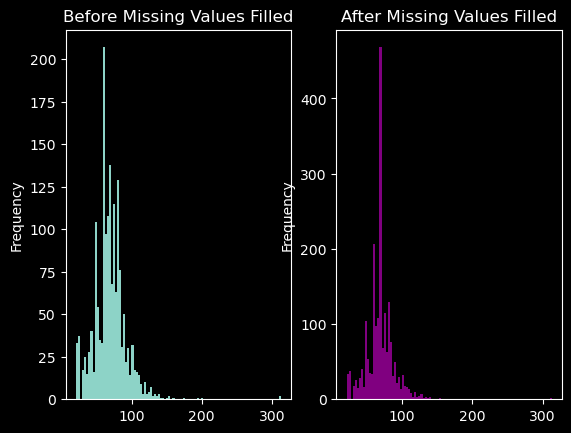

In [129]:
before = house_train['lot_frontage'].copy()
# median is 67, mean is 68, impute with mean

# train
house_train['lot_frontage'] = house_train.lot_frontage.fillna(house_train.lot_frontage.mean())
# test
house_test['lot_frontage'] = house_test.lot_frontage.fillna(house_test.lot_frontage.mean())

fig, axes = plt.subplots(1,2)

before.plot.hist(bins=100, ax = axes[0], title='Before Missing Values Filled')
house_train['lot_frontage'].plot.hist(bins=100, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

In [130]:
house_train.lot_frontage.isnull().sum()

0

`mas_vnr_area`

<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

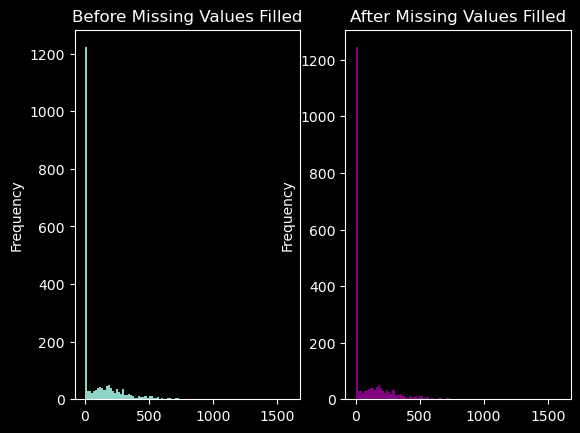

In [131]:
before = house_train['mas_vnr_area'].copy()

# train
house_train['mas_vnr_area'] = house_train.mas_vnr_area.fillna(0) # 0 is the mode, overwhelmingly the case
# test
house_test['mas_vnr_area'] = house_test.mas_vnr_area.fillna(0)

fig, axes = plt.subplots(1,2)

before.plot.hist(bins=100, ax = axes[0], title='Before Missing Values Filled')
house_train['mas_vnr_area'].plot.hist(bins=100, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`bsmtfin_type_1`

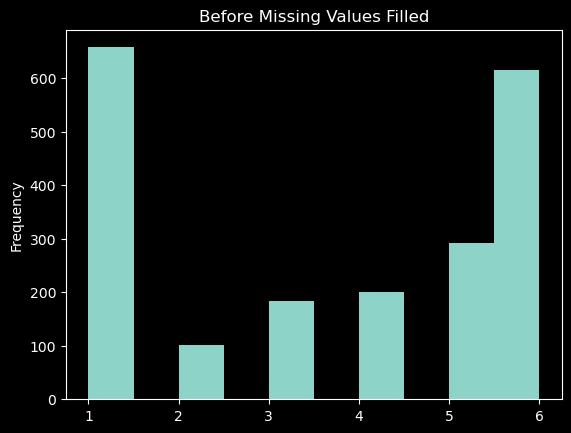

In [132]:
def random_bsmt_imputation(df):
    weights = []
# find distribution of scores amongst the values have aren't NaN, append proportions to weights
    for x in range(1,7):
        weights.append(
        len(df.query(f'bsmtfin_type_1 == {x} and bsmtfin_type_1.notna()'))/
        len(df.query(f'bsmtfin_type_1.notna()'))
        )

# use proportions as probability weights for random assignment of values
    df['bsmtfin_type_1'] = df.bsmtfin_type_1.fillna(np.random.choice(np.arange(1,7), p=weights))

# train
random_bsmt_imputation(house_train)
# test
random_bsmt_imputation(house_test)


before = house_train['bsmtfin_type_1'].plot.hist(title='Before Missing Values Filled')

`bsmt_full_bath`

<AxesSubplot:title={'center':'Before Missing Values Filled'}, ylabel='Frequency'>

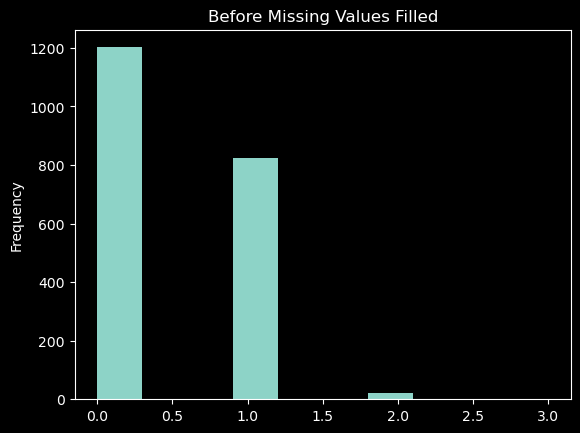

In [133]:

def random_bathroom_imputation(df):
    weights = []
# find distribution of scores amongst the values have aren't NaN, append proportions to weights
    for x in range(0,3):
        weights.append(
        len(df.query(f'bsmt_full_bath == {x} and bsmt_full_bath.notna()'))/
        len(df.query(f'bsmt_full_bath.notna()'))
        )

# normalize so numpy doesn't flag .9998 as not being 1.0
    weights = np.array(weights)
    weights /= weights.sum()

# use proportions as probability weights for random assignment of values
    df['bsmt_full_bath'] = df.bsmt_full_bath.fillna(np.random.choice(np.arange(0,3), p=weights))
    
# train
random_bathroom_imputation(house_train)
# test
random_bathroom_imputation(house_test)

house_train.bsmt_full_bath.plot.hist(title = 'Before Missing Values Filled')

`bsmtfin_sf_1`

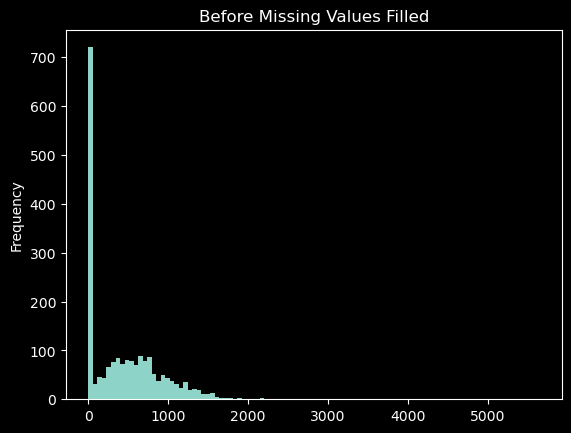

In [134]:
house_train.bsmtfin_sf_1.plot.hist(title='Before Missing Values Filled', bins=100)

# train
house_train['bsmtfin_sf_1'] = house_train.bsmtfin_sf_1.fillna(0) # 0 is the mode, overwhelmingly the case
# test
house_test['bsmtfin_sf_1'] = house_test.bsmtfin_sf_1.fillna(0) # 0 is the mode, overwhelmingly the case

`garage_yr_blt`

0    2005.0
Name: garage_yr_blt, dtype: float64


<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

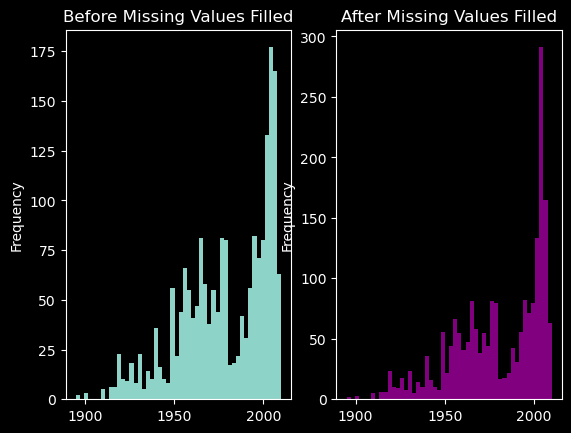

In [135]:

before = house_train['garage_yr_blt']

print(house_train.garage_yr_blt.mode())
# the mean and median for garage_yr_built are all 1978, the mode is 2005
# train
house_train['garage_yr_blt'] = house_train.garage_yr_blt.fillna(2005)
# test
house_test['garage_yr_blt'] = house_test.garage_yr_blt.fillna(2005)
fig, axes = plt.subplots(1,2)

before.plot.hist(bins=50, ax = axes[0], title='Before Missing Values Filled')
house_train['garage_yr_blt'].plot.hist(bins=50, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`garage_qual`

1.9679917398038203


<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

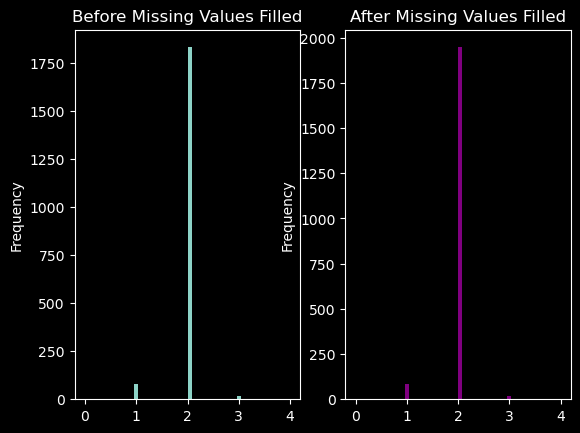

In [136]:

before = house_train['garage_qual']

print(house_train.garage_qual.mean())
# the mean, median  and modefor garage_qual are 2
# train
house_train['garage_qual'] = house_train.garage_qual.fillna(2)
# test
house_test['garage_qual'] = house_test.garage_qual.fillna(2)
fig, axes = plt.subplots(1,2)

before.plot.hist(bins=50, ax = axes[0], title='Before Missing Values Filled')
house_train['garage_qual'].plot.hist(bins=50, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`garage_condition`

1.975735673722251


<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

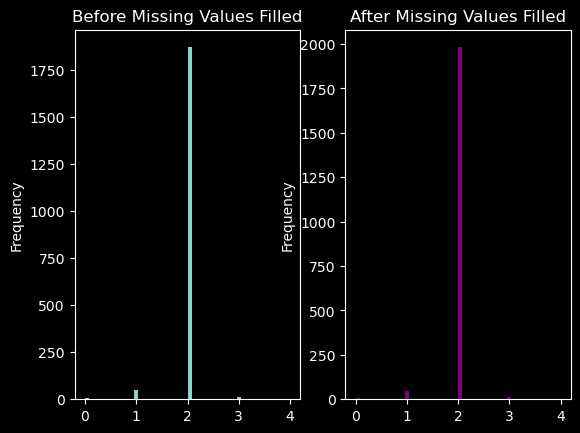

In [137]:

before = house_train['garage_cond']

print(house_train.garage_cond.mean())
# the mean, median  and modefor garage_cond are 2
# train
house_train['garage_cond'] = house_train.garage_cond.fillna(2)
# test
house_test['garage_cond'] = house_test.garage_cond.fillna(2)
fig, axes = plt.subplots(1,2)

before.plot.hist(bins=50, ax = axes[0], title='Before Missing Values Filled')
house_train['garage_cond'].plot.hist(bins=50, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`bsmt_qual`

<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

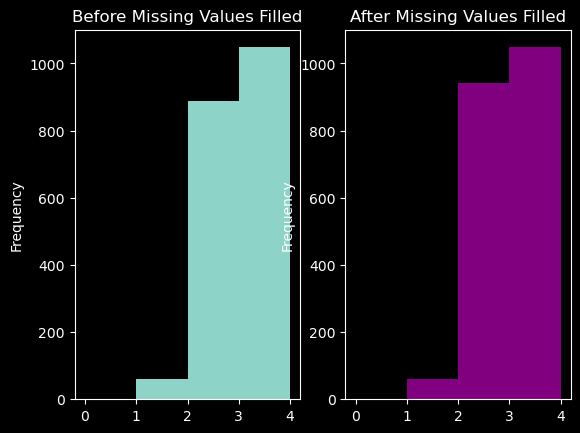

In [138]:
before = house_train['bsmt_qual'] # mode is 2, median is 3, mean is 2.5
# train
house_train['bsmt_qual'] = house_train.bsmt_qual.fillna(house_train.bsmt_qual.mean())
# test
house_test['bsmt_qual'] = house_test.bsmt_qual.fillna(house_test.bsmt_qual.mean())

# plot
fix, axes = plt.subplots(1, 2)
before.plot.hist(bins=4, ax = axes[0], title='Before Missing Values Filled')
house_train['bsmt_qual'].plot.hist(bins=4, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

`garage_area` and `garage_cars`

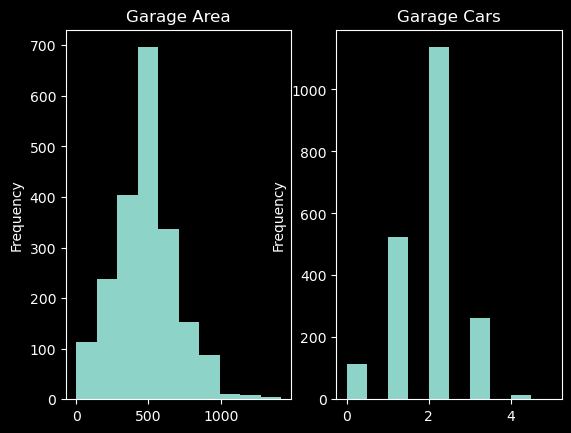

In [139]:
# both of these are just missing 1 value and are close to normally distributed, so we'll insert the median..

fix, axes = plt.subplots(1,2)
house_train.garage_area.plot.hist(title='Garage Area', ax=axes[0])
house_train.garage_cars.plot.hist(title='Garage Cars', ax=axes[1])

for col in ['garage_cars', 'garage_area']:
    house_train[col] = house_train[col].fillna(house_train[col].median())
    house_test[col] = house_test[col].fillna(house_test[col].median())

`total_bsmt_sqft`

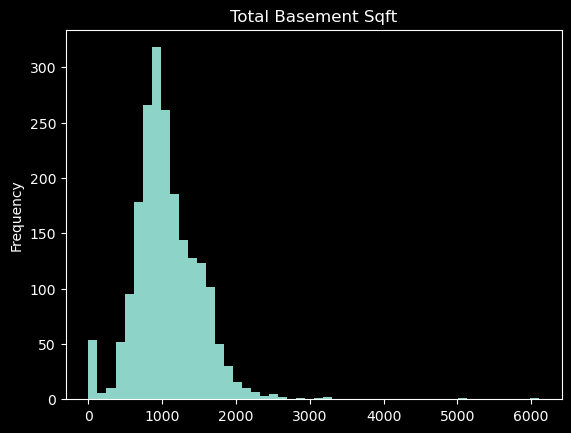

In [140]:
house_train['total_bsmt_sf'].plot.hist(bins=50, title= 'Total Basement Sqft')

house_train['total_bsmt_sf'] = house_train.total_bsmt_sf.fillna(house_train.total_bsmt_sf.mean())
house_test['total_bsmt_sf'] = house_test.total_bsmt_sf.fillna(house_test.total_bsmt_sf.mean())

# Feature Engineering

Combine correlative features

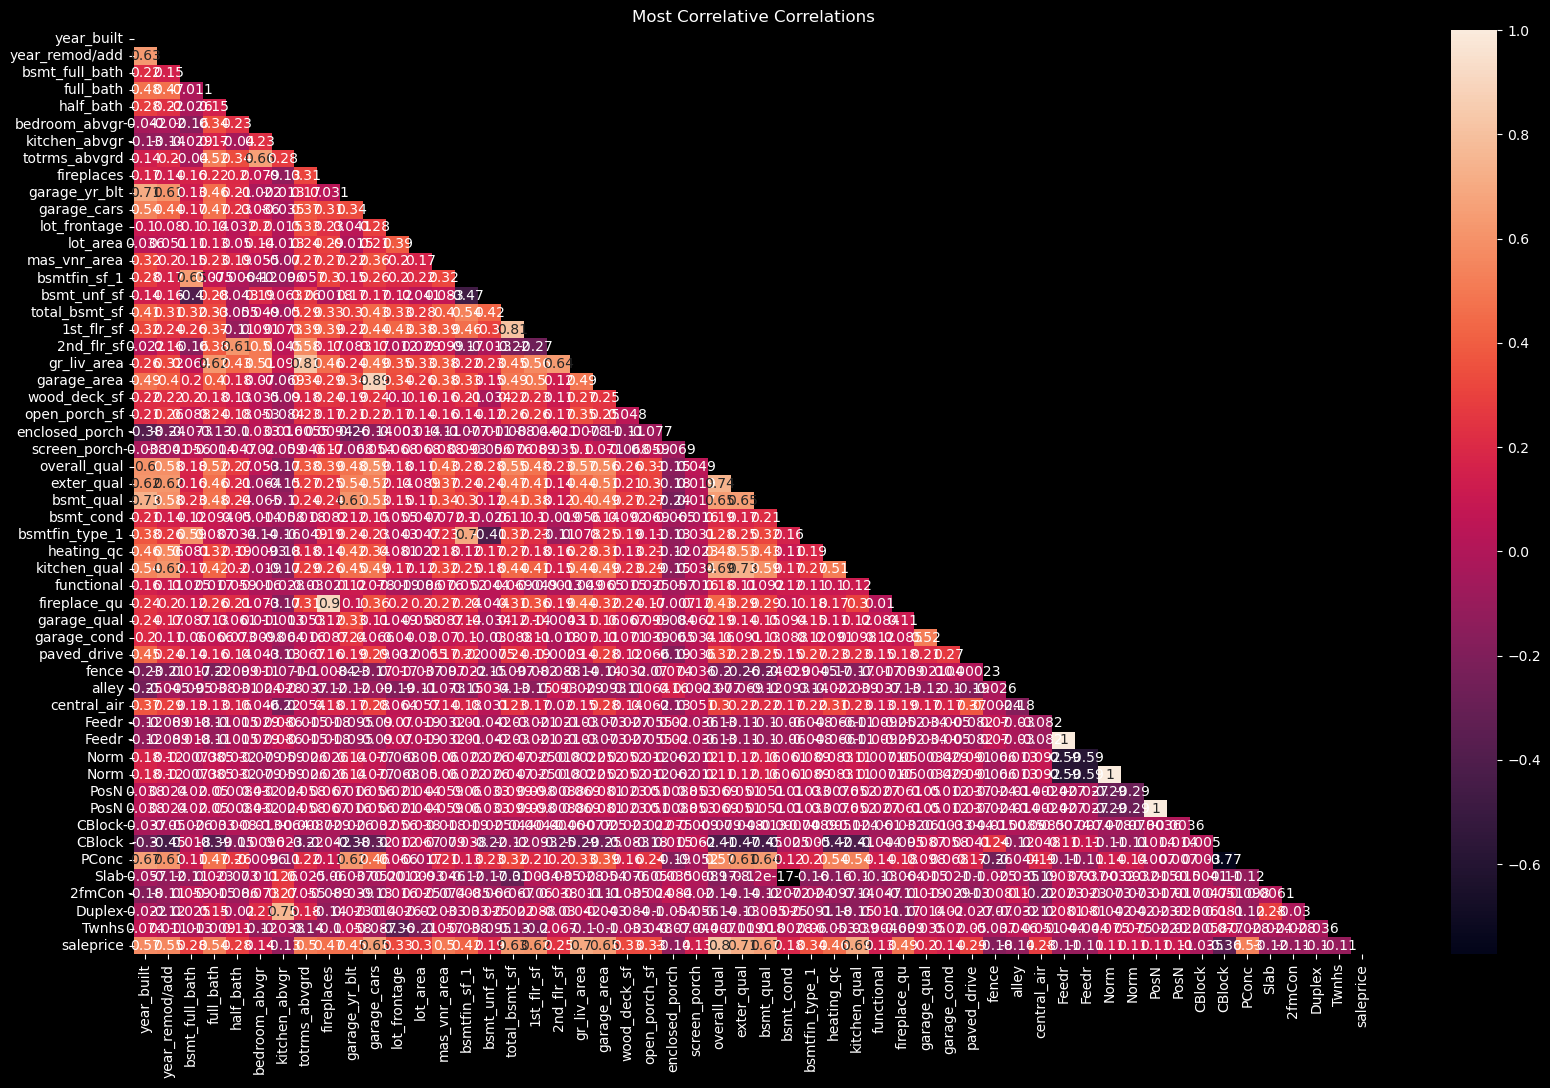

In [141]:
most_corrs = plot_corr_heatmap(correlative_factors.keys(), 'Most Correlative')

sol = (most_corrs[2].where(np.triu(np.ones(most_corrs[2].shape), k=1).astype(bool))
                  .stack()
                  .sort_values(ascending=False))


In [142]:
correlations_df = pd.DataFrame(sol).rename({0:'corr'}, axis=1)

correlations_df.query('corr != 1 and corr != "saleprice"').head(50)

corr
fireplaces     fireplace_qu    0.902962
garage_cars    garage_area     0.893166
totrms_abvgrd  gr_liv_area     0.813333
total_bsmt_sf  1st_flr_sf      0.808665
overall_qual   saleprice       0.800207
kitchen_abvgr  Duplex          0.752788
overall_qual   exter_qual      0.740257
year_built     bsmt_qual       0.730807
exter_qual     kitchen_qual    0.730562
               saleprice       0.712146
year_built     garage_yr_blt   0.708812
bsmtfin_sf_1   bsmtfin_type_1  0.700204
gr_liv_area    saleprice       0.697038
kitchen_qual   saleprice       0.692336
overall_qual   kitchen_qual    0.690639
bsmt_qual      saleprice       0.667041
year_built     PConc           0.666546
bedroom_abvgr  totrms_abvgrd   0.655439
exter_qual     bsmt_qual       0.653536
overall_qual   bsmt_qual       0.652798
garage_area    saleprice       0.650241
garage_cars    saleprice       0.648128
bsmt_full_bath bsmtfin_sf_1    0.645697
bsmt_qual      PConc           0.640028
2nd_flr_sf     gr_liv_area     0.639092
year_built     year_remod/add  0.629116
total_bsmt_sf  saleprice       0.628668
garage_yr_blt  PConc           0.619648
1st_flr_sf     saleprice       0.618486
year_remod/add kitchen_qual    0.617654
full_bath      gr_liv_area     0.617323
year_remod/add exter_qual      0.617170
year_built     exter_qual      0.616441
exter_qual     PConc           0.614890
half_bath      2nd_flr_sf      0.614656
garage_yr_blt  bsmt_qual       0.611055
year_remod/add PConc           0.608503
               garage_yr_blt   0.605456
year_built     overall_qual    0.602964
bsmt_full_bath bsmtfin_type_1  0.593658
garage_cars    overall_qual    0.587213
bsmt_qual      kitchen_qual    0.585931
year_remod/add bsmt_qual       0.584689
               overall_qual    0.584654
totrms_abvgrd  2nd_flr_sf      0.575327
year_built     saleprice       0.571849
overall_qual   PConc           0.571092
gr_liv_area    overall_qual    0.566701
year_remod/add heating_qc      0.563734
garage_area    overall_qual    0.563719

### Overall Condition/Quality

In [143]:
drops = []
engineered = []

In [144]:

def qual_combine(df):
    df['overall_qual_cond'] = (df['overall_qual'] + df['exter_qual'])/2
    df.drop(columns = ['overall_qual', 'exter_qual'], inplace=True)

qual_combine(house_train)
qual_combine(house_test)

def add_to_correlation_dict(feature):
    corr = house_train[[feature, 'saleprice']].corr()
    correlative_factors.update(corr['saleprice'].to_dict())

add_to_correlation_dict('overall_qual_cond')

drop = ['overall_qual', 'exter_qual']
drops += drop
engineered.append('overall_qual_cond')

### Basment Quality

In [145]:
[x for x in house_train.columns if 'bsmt' in x]

def basment_qual(df):
    df['basement_cond'] = (df['bsmt_cond'] + df['bsmtfin_type_1'] + df['bsmtfin_type_2'])/3
    df.drop(columns = ['bsmt_cond', 'bsmt_qual', 'bsmtfin_type_1', 'bsmtfin_type_2'], inplace=True)

basment_qual(house_train)
basment_qual(house_test)

add_to_correlation_dict('basement_cond')
drop = ['bsmt_cond', 'bsmt_qual', 'bsmtfin_type_1', 'bsmtfin_type_2']
drops += drop
engineered.append('basement_cond')

Impute Missing Values for new feature

2.3273182957393495


<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

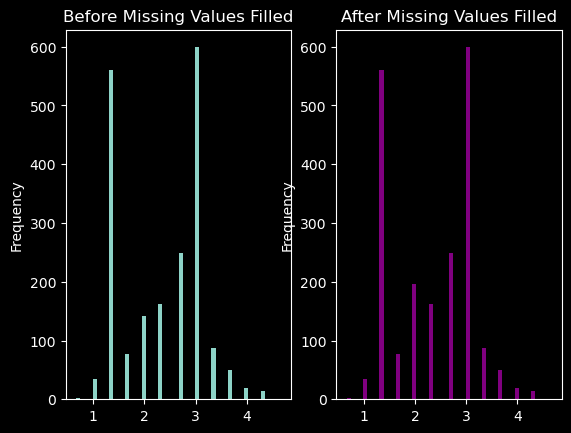

In [146]:
before = house_train['basement_cond']

print(house_train.basement_cond.mean())
# the mean, median  and modefor sement_cond are 2
# train
house_train['basement_cond'] = house_train.basement_cond.fillna(2)
# test
house_test['basement_cond'] = house_test.basement_cond.fillna(2)
fig, axes = plt.subplots(1,2)

before.plot.hist(bins=50, ax = axes[0], title='Before Missing Values Filled')
house_train['basement_cond'].plot.hist(bins=50, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

### Home Square Feet

In [147]:
house_cols = [x for x in house_train.columns if x in ['1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf']]

# these are the same thing 
house_train[house_cols].sum().sum() - house_train['gr_liv_area'].sum()

def handle_sqft(df):
    df['2nd_story'] = [1 if x > 0 else 0 for x in df['2nd_flr_sf']]
    df.drop(columns = [x for x in df.columns if x in ['1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf']],
     inplace = True)

handle_sqft(house_train)
handle_sqft(house_test)

add_to_correlation_dict('2nd_story')
drop = ['1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf']
drops += drop
engineered.append('2nd_story')

### Basement Square Feet

In [148]:
cols = ['bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf']

# these are the same thing
house_train[cols].sum().sum()- house_train['total_bsmt_sf'].sum()

house_train.drop(columns = cols, inplace=True)
house_test.drop(columns = cols, inplace=True)
drops += cols

### Bathrooms

In [149]:
[x for x in house_train.columns if 'bath' in x]

def total_bathrooms(df):
    df['total_bath'] = df['bsmt_full_bath'] + df['bsmt_half_bath']/2 + df['full_bath'] + df['half_bath']/2
    df.drop(columns = ['bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath'], inplace=True)

total_bathrooms(house_train)
total_bathrooms(house_test)

add_to_correlation_dict('total_bath')
drops += ['bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath']
engineered.append('total_bath')

<AxesSubplot:title={'center':'After Missing Values Filled'}, ylabel='Frequency'>

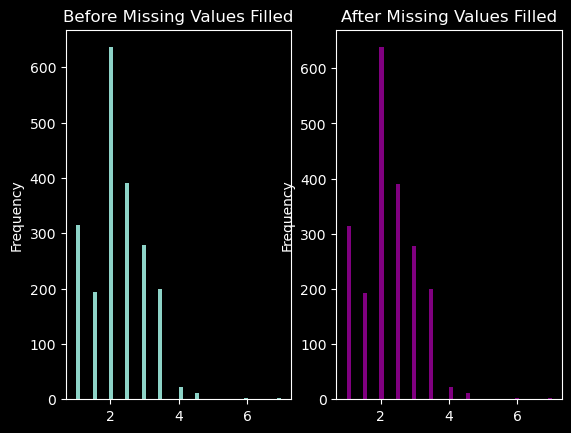

In [150]:
before = house_train['total_bath']


# the mean, median  and modefor total_bath are 2
# train
house_train['total_bath'] = house_train.total_bath.fillna(2)
# test
house_test['total_bath'] = house_test.total_bath.fillna(2)
fig, axes = plt.subplots(1,2)

before.plot.hist(bins=50, ax = axes[0], title='Before Missing Values Filled')
house_train['total_bath'].plot.hist(bins=50, ax = axes[1], color = 'purple', title = 'After Missing Values Filled')

### Porch SF 

In [151]:
def total_porch_sf(df):
    df['total_porch_sf'] = df['open_porch_sf'] + df['enclosed_porch'] + df['3ssn_porch'] + df['screen_porch']
    df.drop(columns = ['open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch'], inplace = True)

total_porch_sf(house_train)
total_porch_sf(house_test)

add_to_correlation_dict('total_porch_sf')
drops += ['open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch']
engineered.append('total_porch_sf')

### Neighborhood Group

In [152]:

def group_neighborhoods(df):
    group_by_neighborhood = house_train.groupby('neighborhood')['saleprice'].mean().sort_values(ascending=False)

    neighbor_hood_dict = {}
    for i, val in enumerate(group_by_neighborhood):
        neighbor_hood_dict.update({group_by_neighborhood.index[i]:i})

    df['neighborhood_price_rank'] = [neighbor_hood_dict[neighborhood] for neighborhood in df.neighborhood]

group_neighborhoods(house_train)
group_neighborhoods(house_test)

# .73, nice!
add_to_correlation_dict('neighborhood_price_rank')
engineered.append('neighborhood_price_rank')

### Remodeled

In [153]:
# train 
def remodeled(df):
    df['updated'] = np.abs(df['year_remod/add'] - df['year_built'])
    df.drop(columns = ['year_remod/add'],inplace = True)

remodeled(house_train)
remodeled(house_test)

# add to correlation dict
add_to_correlation_dict('updated')
drops +=['year_remod/add']
engineered.append('updated')

### Age of Garage

In [154]:
# train

def garage_age(df):
    df['garage_age'] = np.abs(df['yr_sold'] - df['garage_yr_blt'])
    df.drop(columns = ['garage_yr_blt'], inplace=True)

garage_age(house_train)
garage_age(house_test)

add_to_correlation_dict('garage_age')

drops += ['garage_yr_blt']
engineered.append('garage_age')

### Garage Quality

In [155]:
def garage_qual_combine(df):
    df['garage_qual_cond'] = (df['garage_qual'] + df['garage_cond'])/2
    df.drop(columns = ['garage_qual', 'garage_cond'], inplace=True)

garage_qual_combine(house_train)
garage_qual_combine(house_test)

add_to_correlation_dict('garage_qual_cond')
drops += ['garage_qual', 'garage_cond']
engineered.append('garage_qual_cond')

### Age of Home

In [156]:
# train
def home_age(df):
    df['house_age'] = np.abs(df['yr_sold'] - df['year_built'])
    df.drop(columns = ['yr_sold', 'year_built'], inplace=True)

home_age(house_train)
home_age(house_test)

add_to_correlation_dict('house_age')
drops += ['yr_sold', 'year_built']
engineered.append('house_age')

### More Land than House

In [157]:
# train
house_train['land_house_ratio'] = house_train['lot_area']/house_train['gr_liv_area']
# test
house_test['land_house_ratio'] = house_test['lot_area']/house_test['gr_liv_area']
# add to correlations dict

add_to_correlation_dict('land_house_ratio')
engineered.append('house_age')

### Does it have a Pool?

In [158]:
house_train['has_pool'] = [1 if x > 0 else 0 for x in house_train.pool_area]
# test
house_test['has_pool'] = [1 if x > 0 else 0 for x in house_test.pool_area]

add_to_correlation_dict('has_pool')
engineered.append('has_pool')

### Does it have a fireplace?

In [159]:
# train
house_train['has_fireplace'] = [1 if x != 0 else 0 for x in house_train['fireplace_qu']]
# test
house_test['has_fireplace'] = [1 if x != 0 else 0 for x in house_test['fireplace_qu']]
# add to correlations dict
add_to_correlation_dict('has_fireplace')
engineered.append('has_fireplace')


### Housing Market Collapse ~ 2007

In [160]:
def meltdown(df):
    meltdown_list = []
    for idx, row in df.iterrows():
        if row['sale_type'] == 'New' and row['house_age'] < 3:
            meltdown_list.append(1)
        else:
            meltdown_list.append(0)

    df['meltdown'] = meltdown_list

# train
meltdown(house_train)

# test
meltdown(house_test)

add_to_correlation_dict('meltdown')
engineered.append('meltdown')

In [161]:
house_train.shape, house_test.shape

((2051, 140), (878, 134))

Distributions of Features

In [162]:
correlative_factors = {k:v for k,v in correlative_factors.items() if k not in drops}
%store correlative_factors

Stored 'correlative_factors' (dict)


In [163]:
not_in_test = [x for x in house_train.columns if x not in house_test.columns]
not_in_train = [x for x in house_test.columns if x not in house_train.columns]

not_in_test.remove('saleprice')

In [164]:
house_train.drop(columns = not_in_test, inplace=True)
house_test.drop(columns = not_in_train, inplace = True)

In [165]:
not_in_train

['PreCast', 'Metal', 'Roll']

In [166]:
not_in_test

['GrnHill', 'Landmrk', 'ImStucc', 'CompShg', 'Membran', 'NoSeWa']

In [167]:
house_train.shape, house_test.shape

((2051, 134), (878, 131))

In [168]:
set(house_test.columns).symmetric_difference(set(house_train.columns))

{'saleprice'}

In [169]:
engineered

['overall_qual_cond',
 'basement_cond',
 '2nd_story',
 'total_bath',
 'total_porch_sf',
 'neighborhood_price_rank',
 'updated',
 'garage_age',
 'garage_qual_cond',
 'house_age',
 'house_age',
 'has_pool',
 'has_fireplace',
 'meltdown']

In [170]:
house_train.to_csv('../datasets/house_train_improved.csv', index=False)
house_test.to_csv('../datasets/house_test_improved.csv', index = False)